In [1]:
### code to generate the data set
import pdb
import numpy as np
import pandas as pd
from IPython import embed

Example Code 115-116

In [2]:
## membership status
years      = ['2014', '2015', '2016', '2017', '2018']
userStatus = ['bronze', 'silver', 'gold', 'inactive']

# 1000 samples randomly generated from years(arrag type)
userYears = np.random.choice(years, 1000, p = [0.1, 0.1, 0.15, 0.30, 0.35])

# 1000 samples randomly generated from userStatus (array type)
userStats = np.random.choice(userStatus, 1000, p = [0.5, 0.3, 0.1, 0.1])

# combination by two array above (pandas dataframe)
yearJoined = pd.DataFrame({'yearJoined': userYears,
                           'userStats': userStats})


Example Code 116 -117

In [3]:
## email behavior
NUM_EMAILS_SENT_WEEKLY = 3

## types of behavior (never_opens, constant_open_rate, decressing or increasing_open_rate)
def never_opens(period_rng):
    return []

def increasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(1.01, 1.30))
    
def decreasing_open_rate(period_rng):
    return open_rate_with_factor_change(period_rng, np.random.uniform(0.5, 0.99))

def constant_open_rate(period_rng):
    n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
    num_opened = np.random.binomial(n, p, len(period_rng))
    return num_opened

def open_rate_with_factor_change(period_rng, fac):

    if len(period_rng) < 1 :
        return []
    
    times = np.random.randint(0, len(period_rng), int(0.1 * len(period_rng)))
    try:
        n, p = NUM_EMAILS_SENT_WEEKLY, np.random.uniform(0, 1)
        num_opened = np.zeros(len(period_rng))
        for pd in range(0, len(period_rng), 2):
            # set num_opened every two weeks at some opening_rate        
            num_opened[pd:(pd + 2)] = np.random.binomial(n, p, 2)
            # change the opening_rate (positive and less than 1.00 )
            p = max(min(1, p * fac), 0)
    except:
        num_opened[pd] = np.random.binomial(n, p, 1)
    for t in times:
        # 10% of days with zero number
        num_opened[t] = 0
    return num_opened

Example Code 117-118

In [4]:
## donation behavior
def produce_donations(period_rng, user_behavior, num_emails, use_id, user_join_year):
    donation_amounts = np.array([0, 25, 50, 75, 100, 250, 500, 1000, 1500, 2000])
    user_has = np.random.choice(donation_amounts)
    
    # set esti_user_gives vy related parameters 
    user_gives = num_emails  / (NUM_EMAILS_SENT_WEEKLY * len(period_rng)) * user_has
    # set index number of donation_amounts
    user_gives_idx = np.where(user_gives >= donation_amounts)[0][-1]
    # ensure index number is not to be least or most 
    user_gives_idx = max(min(user_gives_idx, len(donation_amounts) - 2), 1)
    
    # set the times of donation by the join_year (previous with more times)
    num_times_gave = np.random.poisson(2) * (2018 - user_join_year)
    
    # set the weekindex for donation in the period
    times = np.random.randint(0, len(period_rng), num_times_gave)

    donations = pd.DataFrame({'user': [], 'amount': [], 'timestamp': []})
    
    for n in range(num_times_gave):
        # change append() to pd.concat(), since append() is not supported.
        # set user, amount, weekstamo for donations
        donations = pd.concat([donations,pd.DataFrame({'user': [use_id],
        'amount': [donation_amounts[user_gives_idx + np.random.binomial(1, .3)]], 
        'timestamp': [str(period_rng[times[n]].start_time + random_weekly_time_delta())]})])

    if donations.shape[0] > 0:
        donations = donations[donations.amount != 0]
    return donations

Example Code 118

In [5]:
# set the donation time randomly (for instance:Timedelta('1 days 20:22:24'))
def random_weekly_time_delta():
    days_of_week = [d for d in range(7)]
    hours_of_day = [h for h in range(11, 23)]
    minute_of_hour = [m for m in range(60)]
    second_of_minute = [s for s in range(60)]
    return pd.Timedelta(str(np.random.choice(days_of_week))     + " days" )   + \
           pd.Timedelta(str(np.random.choice(hours_of_day))     + " hours" )  + \
           pd.Timedelta(str(np.random.choice(minute_of_hour))   + " minutes") + \
           pd.Timedelta(str(np.random.choice(second_of_minute)) + " seconds")

Example Code 119

In [6]:
## run it
behaviors = [never_opens, constant_open_rate, increasing_open_rate, decreasing_open_rate]
user_behaviors = np.random.choice(behaviors, 1000, [0.2, 0.5, 0.1, 0.2])
                                        
rng = pd.period_range('2015-02-14', '2018-06-01', freq = 'W')
emails = pd.DataFrame({'user': [], 'week': [], 'emailsOpened':[]})
donations = pd.DataFrame({'user': [], 'amount': [], 'timestamp': []})

for idx in range(yearJoined.shape[0]):
    ## randomly generate the date when a user would have joined
    join_date = pd.Timestamp(yearJoined.iloc[idx].yearJoined) + \
                pd.Timedelta(str(np.random.randint(0, 365)) + ' days')
    join_date = min(join_date, pd.Timestamp('2018-06-01'))
    
    # user should not receive emails or make donations before joining
    # thank you to Murray M Gillin for reporting errata and suggesting this correction
    # rng.start_time indicates "2018-02-19" in "2018-02-19/2018-02-25"
    user_rng = rng[rng.start_time > join_date]
    
    if len(user_rng) < 1:
        continue
    
    # Generate behaviors randomly
    # user_behaviors[idx] used the different function above (for instance, constant_open_rate(user_rng))
    info = user_behaviors[idx](user_rng)

    if len(info) == len(user_rng):
        # set user_id, week_index, emails_Opened for email
        emails = pd.concat([emails, pd.DataFrame({'user': [idx] * len(info), 
        'week': [str(r.start_time) for r in user_rng], 'emailsOpened': info})])

    donations = pd.concat([donations,produce_donations(user_rng, user_behaviors[idx],
    sum(info), idx, join_date.year)])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16172\3966802417.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  num_opened[pd] = np.random.binomial(n, p, 1)


In [7]:
emails

,user,week,emailsOpened
0,2.0,2015-02-23 00:00:00,1.0
1,2.0,2015-03-02 00:00:00,0.0
2,2.0,2015-03-09 00:00:00,0.0
3,2.0,2015-03-16 00:00:00,0.0
4,2.0,2015-03-23 00:00:00,0.0
...,...,...,...
168,999.0,2018-04-30 00:00:00,3.0
169,999.0,2018-05-07 00:00:00,3.0
170,999.0,2018-05-14 00:00:00,3.0
171,999.0,2018-05-21 00:00:00,3.0


In [8]:
donations

,user,amount,timestamp
0,2.0,25.0,2015-11-27 19:27:44
0,2.0,25.0,2017-06-15 13:57:55
0,2.0,50.0,2018-04-09 11:11:00
0,2.0,25.0,2017-08-16 14:36:32
0,2.0,50.0,2016-11-11 22:08:02
...,...,...,...
0,999.0,1500.0,2018-05-15 19:43:12
0,999.0,1500.0,2015-08-04 12:54:43
0,999.0,2000.0,2016-03-16 17:48:30
0,999.0,2000.0,2015-05-02 11:50:27


In [9]:
## get rid of zero donations and zero emails
emails = emails[emails.emailsOpened != 0]
yearJoined.index.name = 'user'

# yearJoined.to_csv('data/year_joined.csv', index = False)
# donations.to_csv( 'data/donations.csv',   index = False)
# emails.to_csv('data/emails.csv',      index = False)

Plot the donation amount in different months

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14776\3348237874.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  donations.groupby(pd.Grouper(freq="M")).amount.sum().plot()


<Axes: xlabel='timestamp'>

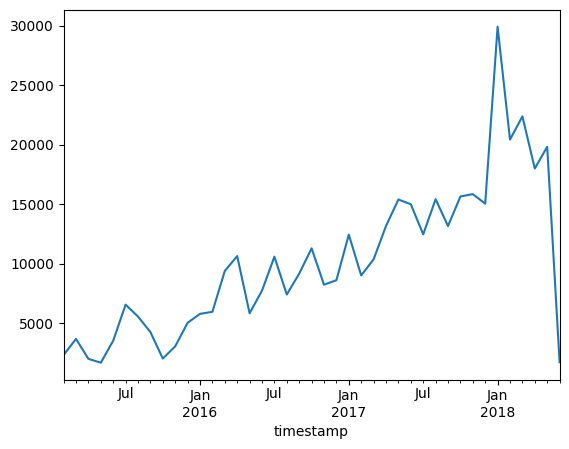

In [13]:
donations.set_index(pd.to_datetime(donations.timestamp), inplace = True)
donations.sort_index(inplace = True)
donations.groupby(pd.Grouper(freq="M")).amount.sum().plot()